<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!hostname
!python -c "import jax; print(jax.default_backend())"
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.99' # NOTE: jax preallocates GPU (default 75%)
from functools import partial

import matplotlib.pyplot as plt

import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap
import jax_cosmo as jc
from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, make_ode_fn
from montecosmo.bricks import lpt as mylpt, Planck18
from montecosmo.models import get_pk_fn

feynmangpu01.cluster.local
gpu


2024-07-22 00:35:17.373896: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
mesh_shape = 256*np.array([1,1,1])
box_shape  = np.array([640.,640.,640.])
n_snapshots = 4
rsd = False

multipoles = [0,2,4]
pk_fn = get_pk_fn(mesh_shape, box_shape, multipoles=multipoles)
zeros_mesh = jnp.zeros(mesh_shape)

def run_simulation(cosmology, a_lpt=1., a_obs=1., lpt_order=1):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmology, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
    initial_conditions = linear_field(mesh_shape, box_shape, pk_fn, seed=jr.key(0))

    # Initial displacement
    particles = jnp.indices(mesh_shape).reshape(3,-1).T
    cosmology._workspace = {}  # FIX ME: this a temporary fix
    dx, p, f = mylpt(cosmology, initial_conditions, particles, a_lpt, lpt_order)
    if a_obs == a_lpt:
        res = particles + dx
    else:
        # Evolve the simulation forward
        snapshots = jnp.linspace(a_lpt, a_obs, n_snapshots)
        res = odeint(make_ode_fn(mesh_shape), jnp.stack([particles+dx, p]), snapshots, cosmology, rtol=1e-5, atol=1e-5)
        res = res[-1,0]
        p = res[-1,1]

    if rsd:        
        dx_rsd = p / (jnp.sqrt(jc.background.Esqr(cosmology, a_obs)) * a_obs**2)
        return res + dx_rsd * jnp.array([0,0,1])
    else:
        return res

In [25]:
cosmology = Planck18()
print(f"Fiducial {cosmology}")
a_lpt, a_obs = 0.1, 0.5
res = jit(partial(run_simulation, a_lpt=a_obs, a_obs=a_obs, lpt_order=1))(cosmology)
pk_jlpt1 = pk_fn(compensate_cic(cic_paint(zeros_mesh, res)))
res = jit(partial(run_simulation, a_lpt=a_obs, a_obs=a_obs, lpt_order=2))(cosmology)
pk_jlpt2 = pk_fn(compensate_cic(cic_paint(zeros_mesh, res)))
res = jit(partial(run_simulation, a_lpt=a_lpt, a_obs=a_obs, lpt_order=1))(cosmology)
pk_jpm1 = pk_fn(compensate_cic(cic_paint(zeros_mesh, res)))
res = jit(partial(run_simulation, a_lpt=a_lpt, a_obs=a_obs, lpt_order=2))(cosmology)
pk_jpm2 = pk_fn(compensate_cic(cic_paint(zeros_mesh, res)))
del res

Fiducial Cosmological parameters: 
    h:        0.6766 
    Omega_b:  0.049 
    Omega_c:  0.2607 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9665 
    sigma8:   0.8102


/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/sit

In [44]:
from pmwd import (Configuration, Cosmology, SimpleLCDM,
    boltzmann, linear_power, growth, white_noise, linear_modes, lpt, scatter, nbody)
import jax


ptcl_spacing = 2.5 # Mpc/h
ptcl_grid_shape = (256,)*3
def run_pmwd(a_lpt=1., a_obs=1., lpt_order=1):
    jax.config.update("jax_enable_x64", True)
    conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=1, 
                         a_start=a_lpt, a_stop=a_obs, lpt_order=lpt_order,
                         cosmo_dtype=jnp.float32, a_nbody_maxstep=1e-4)
    # cosmo = Cosmology.from_sigma8(conf, sigma8=0.8102, n_s=0.9665, Omega_m=0.3097, Omega_b=0.0490, h=0.6766)
    # XXX: sigma8 redshift dependant???
    cosmo = Cosmology(conf, A_s_1e9=np.exp(3.047)/10, n_s=0.9665, Omega_m=0.3097, Omega_b=0.0490, h=0.6766)
    print(conf)
    cosmo = boltzmann(cosmo, conf)

    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmology, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
    initial_conditions = linear_field(mesh_shape, box_shape, pk_fn, seed=jr.key(0))
    init_modes = jnp.fft.rfftn(initial_conditions)

    # seed = 0
    # modes = white_noise(seed, conf)
    field = jr.normal(jr.key(0), mesh_shape)
    modes = jnp.fft.rfftn(field, norm="ortho")
    modes = linear_modes(modes, cosmo, conf)

    ratio = jnp.fft.irfftn(modes) / initial_conditions
    print("ratio mean and std:", ratio.mean(), ratio.std())
    print("growth:", growth(a_lpt, cosmo, conf, order=lpt_order))
    
    # return jnp.fft.irfftn(init_modes), jnp.fft.irfftn(modes)

    # from pmwd.pm_util import fftfreq
    # kvec = fftfreq(conf.ptcl_grid_shape, conf.ptcl_spacing, dtype=conf.float_dtype)
    # k = jnp.sqrt(sum(k**2 for k in kvec))
    # Plin = linear_power(k, None, cosmo, conf)
    
    # from jaxpm.kernels import fftk
    # k = jnp.logspace(-4, 1, 128)
    # pk = jc.power.linear_matter_power(cosmology, k)
    # pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
    # kvec = fftk(mesh_shape)
    # kmesh = sum((kk / box_shape[i] * mesh_shape[i])**2 for i, kk in enumerate(kvec))**0.5
    # pkmesh = pk_fn(kmesh) * (mesh_shape[0] * mesh_shape[1] * mesh_shape[2]) / (box_shape[0] * box_shape[1] * box_shape[2])
    # return pkmesh, Plin

    
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    # ptcl, obsvbl = lpt(init_modes * ratio.mean(), cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    # return scatter(ptcl, conf)
    jax.config.update("jax_enable_x64", False)
    if rsd:
        dx_rsd = ptcl.disp / (jnp.sqrt(jc.background.Esqr(cosmology, a_obs)))
        res = ptcl.pos() + dx_rsd * jnp.array([0,0,1])
    else:
        res = ptcl.pos()
    
    return cic_paint(zeros_mesh, res/ptcl_spacing)
    # return ptcl.pos().astype(jnp.float32)

In [45]:
from jaxpm.growth import growth_factor, growth_rate, dGfa, growth_factor_second, growth_rate_second, dGf2a
a = jnp.atleast_1d(a_lpt)
growth_factor(cosmology, a), growth_factor_second(cosmology, a), growth_rate(cosmology, a), growth_rate_second(cosmology, a), 3/7, (0.3097)**(5/9), 2*(0.3097)**(6/11)

/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


(Array([0.127], dtype=float32),
 Array([0.016], dtype=float32),
 Array([0.999], dtype=float32),
 Array([1.998], dtype=float32),
 0.42857142857142855,
 0.521422249037324,
 1.0552650682771587)

In [46]:
res_pmwd = run_pmwd(a_obs, a_obs, 1)
pk_lptwd1 = pk_fn(compensate_cic(res_pmwd))
res_pmwd = run_pmwd(a_obs, a_obs, 2)
pk_lptwd2 = pk_fn(compensate_cic(res_pmwd))
res_pmwd = run_pmwd(a_lpt, a_obs, 1)
pk_pmwd1 = pk_fn(compensate_cic(res_pmwd))
res_pmwd = run_pmwd(a_lpt, a_obs, 2)
pk_pmwd2 = pk_fn(compensate_cic(res_pmwd))

Configuration(ptcl_spacing=2.5,
              ptcl_grid_shape=(256, 256, 256),
              mesh_shape=(256, 256, 256),
              cosmo_dtype=dtype('float32'),
              pmid_dtype=dtype('int16'),
              float_dtype=dtype('float32'),
              k_pivot_Mpc=0.05,
              T_cmb=2.7255,
              M=1.98847e+40,
              L=3.0856775815e+22,
              T=3.0856775815e+17,
              transfer_fit=True,
              transfer_fit_nowiggle=False,
              transfer_lgk_min=-4,
              transfer_lgk_max=3,
              transfer_lgk_maxstep=0.0078125,
              growth_rtol=0.00034526698300124393,
              growth_atol=0.00034526698300124393,
              growth_inistep=(1, None),
              lpt_order=1,
              a_start=0.5,
              a_stop=0.5,
              a_lpt_maxstep=0.0078125,
              a_nbody_maxstep=0.0001,
              symp_splits=((0, 0.5), (1, 0.5)),
              chunk_size=16777216)
ratio mean and std: 20

/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/pmwd/particles.py:207: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  pos %= jnp.array(conf.box_size, dtype=dtype)


Configuration(ptcl_spacing=2.5,
              ptcl_grid_shape=(256, 256, 256),
              mesh_shape=(256, 256, 256),
              cosmo_dtype=dtype('float32'),
              pmid_dtype=dtype('int16'),
              float_dtype=dtype('float32'),
              k_pivot_Mpc=0.05,
              T_cmb=2.7255,
              M=1.98847e+40,
              L=3.0856775815e+22,
              T=3.0856775815e+17,
              transfer_fit=True,
              transfer_fit_nowiggle=False,
              transfer_lgk_min=-4,
              transfer_lgk_max=3,
              transfer_lgk_maxstep=0.0078125,
              growth_rtol=0.00034526698300124393,
              growth_atol=0.00034526698300124393,
              growth_inistep=(1, None),
              lpt_order=2,
              a_start=0.5,
              a_stop=0.5,
              a_lpt_maxstep=0.0078125,
              a_nbody_maxstep=0.0001,
              symp_splits=((0, 0.5), (1, 0.5)),
              chunk_size=16777216)
ratio mean and std: 20

/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/pmwd/particles.py:207: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  pos %= jnp.array(conf.box_size, dtype=dtype)


Configuration(ptcl_spacing=2.5,
              ptcl_grid_shape=(256, 256, 256),
              mesh_shape=(256, 256, 256),
              cosmo_dtype=dtype('float32'),
              pmid_dtype=dtype('int16'),
              float_dtype=dtype('float32'),
              k_pivot_Mpc=0.05,
              T_cmb=2.7255,
              M=1.98847e+40,
              L=3.0856775815e+22,
              T=3.0856775815e+17,
              transfer_fit=True,
              transfer_fit_nowiggle=False,
              transfer_lgk_min=-4,
              transfer_lgk_max=3,
              transfer_lgk_maxstep=0.0078125,
              growth_rtol=0.00034526698300124393,
              growth_atol=0.00034526698300124393,
              growth_inistep=(1, None),
              lpt_order=1,
              a_start=0.1,
              a_stop=0.5,
              a_lpt_maxstep=0.0078125,
              a_nbody_maxstep=0.0001,
              symp_splits=((0, 0.5), (1, 0.5)),
              chunk_size=16777216)
ratio mean and std: 20

/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/pmwd/particles.py:207: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  pos %= jnp.array(conf.box_size, dtype=dtype)


Configuration(ptcl_spacing=2.5,
              ptcl_grid_shape=(256, 256, 256),
              mesh_shape=(256, 256, 256),
              cosmo_dtype=dtype('float32'),
              pmid_dtype=dtype('int16'),
              float_dtype=dtype('float32'),
              k_pivot_Mpc=0.05,
              T_cmb=2.7255,
              M=1.98847e+40,
              L=3.0856775815e+22,
              T=3.0856775815e+17,
              transfer_fit=True,
              transfer_fit_nowiggle=False,
              transfer_lgk_min=-4,
              transfer_lgk_max=3,
              transfer_lgk_maxstep=0.0078125,
              growth_rtol=0.00034526698300124393,
              growth_atol=0.00034526698300124393,
              growth_inistep=(1, None),
              lpt_order=2,
              a_start=0.1,
              a_stop=0.5,
              a_lpt_maxstep=0.0078125,
              a_nbody_maxstep=0.0001,
              symp_splits=((0, 0.5), (1, 0.5)),
              chunk_size=16777216)
ratio mean and std: 20

/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/pmwd/particles.py:207: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  pos %= jnp.array(conf.box_size, dtype=dtype)


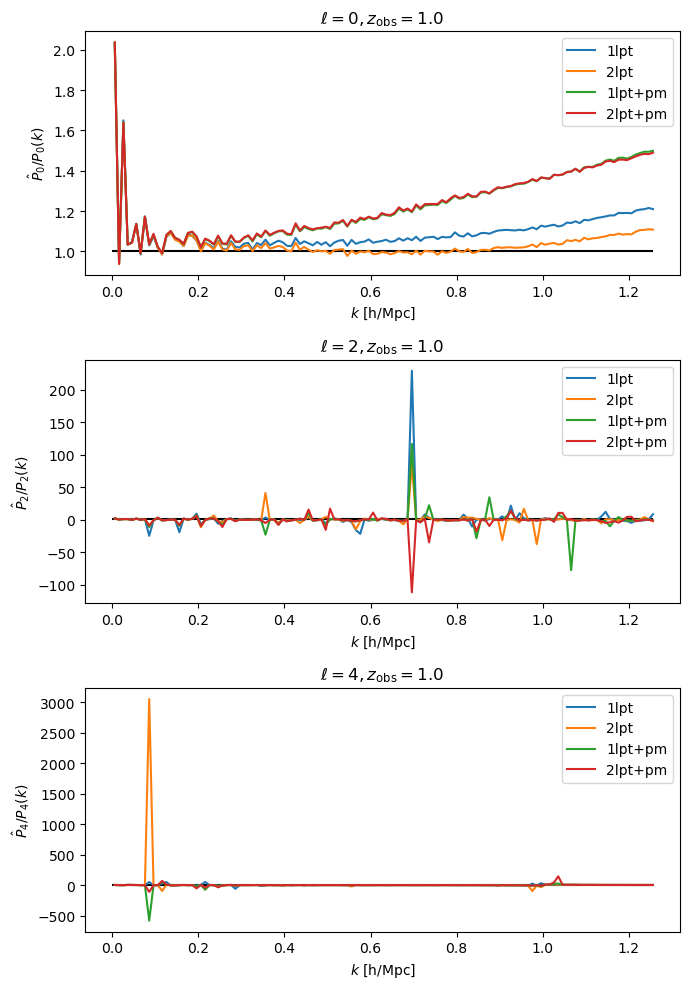

In [47]:
plot_ratio = True
plt.figure(figsize=(7,10))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole+1], *args, **kwargs)
    plot2_fn = lambda pk1, pk2, *args, **kwargs: plt.plot(pk1[0], pk2[i_pole+1]/pk1[i_pole+1], *args, **kwargs)
    # plot_fn = lambda pk, *args, **kwargs: plt.loglog(pk[0], pk[i_pole+1], *args, **kwargs)

    if plot_ratio:
        plt.hlines(1, 0, pk_jlpt1[0].max(), 'k')
        plot2_fn(pk_jlpt1, pk_lptwd1, 'C0', label=f"1lpt")
        plot2_fn(pk_jlpt2, pk_lptwd2, 'C1', label=f"2lpt")
        plot2_fn(pk_jpm1, pk_pmwd1, 'C2', label=f"1lpt+pm")
        plot2_fn(pk_jpm2, pk_pmwd2, 'C3', label=f"2lpt+pm")
        plt.ylabel(f"$\\hat P_{multipole}/P_{multipole}(k)$")  
    else:
        plot_fn(pk_jlpt1, '+C0', label=f"jaxpm 1lpt")
        plot_fn(pk_jlpt2, '+C1', label=f"jaxpm 2lpt")
        plot_fn(pk_jpm1, '+C2', label=f"jaxpm 1lpt+pm")
        plot_fn(pk_jpm2, '+C3', label=f"jaxpm 2lpt+pm")

        plot_fn(pk_lptwd1, 'C0', label=f"pmwd 1lpt")    
        plot_fn(pk_lptwd2, 'C1', label=f"pmwd 2lpt")
        plot_fn(pk_pmwd1, 'C2', label=f"pmwd 1lpt+pm")    
        plot_fn(pk_pmwd2, 'C3', label=f"pmwd 2lpt+pm")
        plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")  

    plt.legend()
    plt.xlabel("$k$ [h/Mpc]"),
    plt.title("$\\ell="+f"{multipole}, "+"z_{\\text{obs}}="+f"{1/a_obs-1:.1f}$")
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), f"pkl_rsd{rsd:b}_smooth{smooth:b}.svg")
# plt.savefig('pkl_history.svg', dpi=200, bbox_inches='tight')
plt.show();